## Text Extraction

##### Author: Alex Sherman | alsherman@deloitte.com


Agenda:
- Extract Text from Word Documents
- Identify style (e.g. Bold, Font) and metadata (e.g. author) associated with document text
- Understand docx XML tag definitions
- Learn how to interact with Zip Files
- Identify content surrounding key piece of text
- Extract text from a pdf with pdfminer.six

In [1]:
import os
from IPython.display import Image
from IPython.core.display import display, HTML
from configparser import ConfigParser, ExtendedInterpolation
import zipfile
import lxml
import subprocess
import docx
from bs4 import BeautifulSoup
import PyPDF2
from PIL import Image as Img
import pytesseract

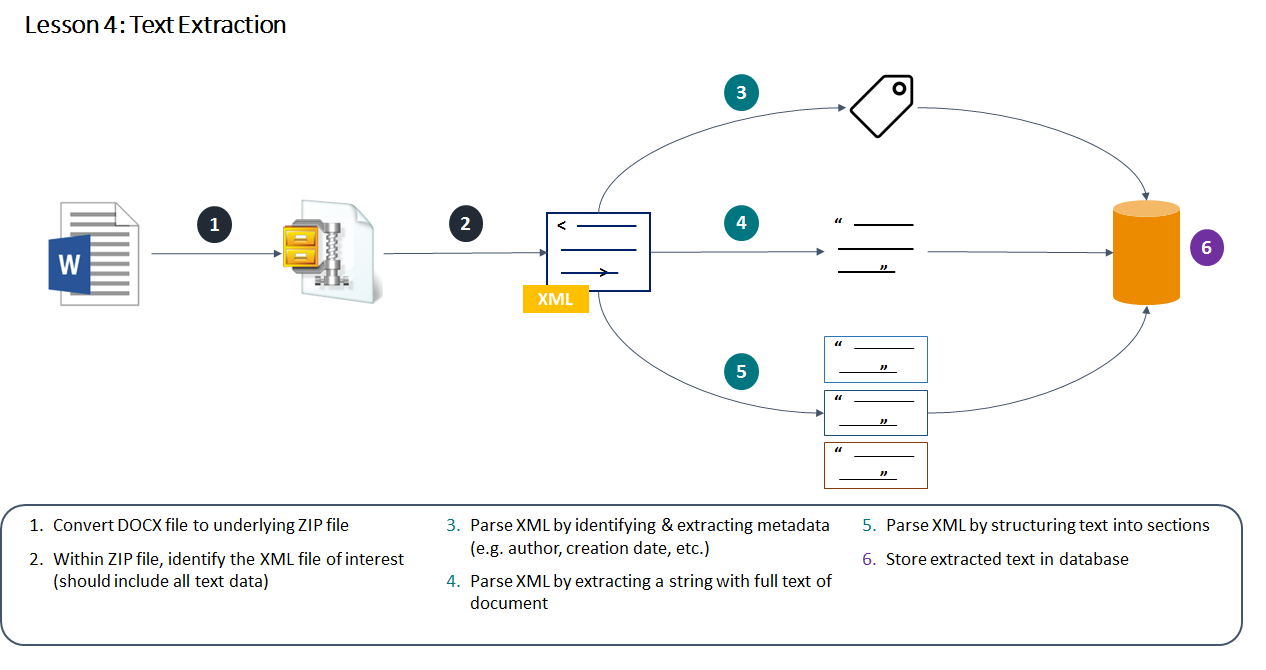

In [2]:
Image("../../raw_data/images/lesson4_text_extraction.png", width=800, height=700)

In [17]:
import os
from IPython.core.display import display, HTML
from configparser import ConfigParser, ExtendedInterpolation

config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

PDF_NAME = config['TEXT_EXTRACTION']['PDF_NAME']
DOCX_PATH = config['TEXT_EXTRACTION']['DOCX_PATH']
XML_PATH = config['TEXT_EXTRACTION']['XML_PATH']
EXTRACT_PATH = config['TEXT_EXTRACTION']['EXTRACT_PATH']
EXAMPLE_ZIP = config['TEXT_EXTRACTION']['EXAMPLE_ZIP']
EXAMPLE_PDF = config['TEXT_EXTRACTION']['EXAMPLE_PDF']
PDFMINER = config['TEXT_EXTRACTION']['PDFMINER']
IMAGE_MAGICK_PATH = config['TEXT_EXTRACTION']['IMAGE_MAGICK_PATH']
TESSERACT_EXE_PATH = config['TEXT_EXTRACTION']['TESSERACT_EXE_PATH']
TESSERACT_DATA_PATH = config['TEXT_EXTRACTION']['TESSERACT_DATA_PATH']

### python-docx

python-docx is a Python library for creating, updating, and extracting text from Microsoft Word (.docx) files.

In [18]:
sqlalchemy_url = 'https://python-docx.readthedocs.io/en/latest/'
iframe = '<iframe src={} width=1100 height=300></iframe>'.format(sqlalchemy_url)
HTML(iframe)

In [19]:
# the Document method reads the text, style, and formatting of a word .docx document
import docx
doc = docx.Document(DOCX_PATH)

In [6]:
# view the methods and attributes of a doc
print(dir(doc))

['_Document__body', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_block_width', '_body', '_element', '_parent', '_part', 'add_heading', 'add_page_break', 'add_paragraph', 'add_picture', 'add_section', 'add_table', 'core_properties', 'element', 'inline_shapes', 'paragraphs', 'part', 'save', 'sections', 'settings', 'styles', 'tables']


### Paragraphs

Word paragraphs contain the text of the document. However, the table text, headers, footers, are not included in paragraphs.

In [20]:
# get all paragraphs 
paragraphs = doc.paragraphs

In [21]:
# view the docx paragraph objects
paragraphs[0:5]

In [22]:
# count all paragraphs in the document
len(paragraphs)

2579

In [28]:
# only include with text (ignore empty strings)
paragraphs = [p for p in paragraphs if p.text.strip() != '']

In [29]:
# view the text of the first paragraph
paragraphs[0].text

'SOUTHWEST AIRLINES CO.'

### Style

In [30]:
# view the methods and attributes of a paragraph
print(dir(paragraphs[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_element', '_insert_paragraph_before', '_p', '_parent', 'add_run', 'alignment', 'clear', 'insert_paragraph_before', 'paragraph_format', 'part', 'runs', 'style', 'text']


In [31]:
# get the paragraph style
paragraphs[0].style.name

'Normal'

In [32]:
# Identify if paragraph text has 'Heading' style
'heading' in paragraphs[0].style.name.lower()

False

In [15]:
# view all the heading styles in the doc
set(p.style.name for p in paragraphs if 'heading' in p.style.name.lower())

{'Heading 1', 'Heading 2'}

### Exercise
 1. count how many paragraphs have a heading style
 2. store the text of all the paragraphs with a heading style

In [16]:
# store all heading paragraphs
headings = [p.text.strip() for p in paragraphs if 'heading' in p.style.name.lower()]

print('# heading paragraphs: {}\n'.format(len(headings)))
headings[0:10]

# heading paragraphs: 145



['UNITED STATES',
 'PART I',
 'Company Overview',
 'Industry',
 'Company Operations Route Structure',
 'General',
 'International Service',
 'Cost Structure',
 'Fare Structure',
 'General']

### Runs

Each paragraph may contain one or more runs. A run denotes the style attached to the text in a paragraph. Every time the style change (e.g. from bold to normal text) a new run is added.

In [17]:
runs = paragraphs[0].runs
runs

In [18]:
# View all the runs in the paragraph
[run.text for run in runs]

['', '', 'SOUTHWEST AIRLINES CO.']

In [19]:
# each run contains a portion of text from the paragraph
run = runs[2]
run.text

'SOUTHWEST AIRLINES CO.'

### Run style

- Each run contains style information such as bold, italic, or underline. 
- The style information will be True, False, or None
- A value of None indicates the run has no directly-applied style value and so will inherit the value of its containing paragraph.

In [20]:
# view the methods and attributes of a run
print(dir(run))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_element', '_parent', '_r', 'add_break', 'add_picture', 'add_tab', 'add_text', 'bold', 'clear', 'element', 'font', 'italic', 'part', 'style', 'text', 'underline']


In [21]:
# font size
run.font.size.pt

12.0

In [22]:
print(run.bold)

True


In [23]:
print(run.italic)

None


In [24]:
print(run.underline)

None


In [25]:
# View all the run stlye 
[run.bold for run in runs]

[None, None, True]

## Exercise

#### Find all the bold runs

- Iterate through all the runs in all the paragraphs to identify any run with a bold style applied.
- Store all the bold text in a list named bold_text
- Do not include empty strings (e.g. '') 
- print the first 10 items in bold_text

In [26]:
bold_text = []
for paragraph in paragraphs:
    for run in paragraph.runs:
        if run.bold and run.text.strip() != '':
            text = run.text
            bold_text.append(text)

bold_text[0:10]

['SOUTHWEST AIRLINES CO.',
 '2016 ANNUAL REPORT TO SHAREHOLDERS',
 'SECURITIES AND EXCHANGE COMMISSION',
 'Washington, D.C. 20549',
 'FORM 10-K',
 'ANNUAL',
 'REPORT',
 'PURSUANT',
 'TO',
 'SECTION']

### Create a function to determine if all runs in a paragraph are bold

- Name the function is_bold
- Return True if all runs (with text) in a paragraph are bold
- Test the function by adding all the bold paragraphs to a list named bold_paragraphs
- Print the first 10 paragraphs in bold_paragraphs

In [27]:
# create the function is_bold
def is_bold(paragraph):   
    runs_are_bold = [run.bold for run in paragraph.runs if run.text != '']

    if runs_are_bold and all(runs_are_bold):  # runs_are_bold evaluates as False if the list is empty
        return True
    return False

In [28]:
# test the is_bold function
bold_paragraphs = []
for paragraph in paragraphs:
    if is_bold(paragraph):
        bold_paragraphs.append(paragraph.text)

bold_paragraphs[0:10]

['SOUTHWEST AIRLINES CO.',
 '2016 ANNUAL REPORT TO SHAREHOLDERS',
 'SECURITIES AND EXCHANGE COMMISSION',
 'Washington, D.C. 20549',
 'FORM 10-K',
 'Southwest Airlines Co.',
 'Securities registered pursuant to Section 12(b) of the Act:',
 'Title of Each Class\tName of Each Exchange on Which Registered',
 'Securities registered pursuant to Section 12(g) of the Act: None',
 'DOCUMENTS INCORPORATED BY REFERENCE']

### Tables

In [29]:
# identify all document tables
tables = doc.tables

In [30]:
# view a few table objects
tables[0:5]

In [31]:
# count the document tables
len(tables)

58

In [32]:
# view the methods and attributes of a table
print(dir(tables[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cells', '_column_count', '_element', '_parent', '_tbl', '_tblPr', 'add_column', 'add_row', 'alignment', 'autofit', 'cell', 'column_cells', 'columns', 'part', 'row_cells', 'rows', 'style', 'table', 'table_direction']


In [33]:
# view the cells of a table

table_cells = [cell.text.strip() for cell in tables[0]._cells if cell.text != '']
table_cells[0:10]

['PART I',
 'Item 1.',
 'Business',
 '1',
 'Item 1A.',
 'Risk Factors',
 '22',
 'Item 1B.',
 'Unresolved Staff Comments',
 '30']

### Core Properties

In [34]:
print(dir(doc.core_properties))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_element', 'author', 'category', 'comments', 'content_status', 'created', 'identifier', 'keywords', 'language', 'last_modified_by', 'last_printed', 'modified', 'revision', 'subject', 'title', 'version']


In [35]:
doc.core_properties.title

'Southwest Airlines Co. 2016 Annual Report'

In [36]:
doc.core_properties.subject

''

In [37]:
doc.core_properties.author

''

In [38]:
doc.core_properties.created

datetime.datetime(2018, 1, 3, 22, 53, 10)

In [39]:
doc.core_properties.revision

0

## Explore docx xml
Every word document is a zip of xml files. To test this, change the extension of any word file from .docx to .xml. 

Inside each zip, a directory named word contains document.xml. This file contains all of the xml for the word document.

To open the zip we use the package zipfile

In [33]:
XML_PATH

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_health\\raw_data\\docx_example.zip'

### zipfile

ZipFile - The class for reading and writing ZIP files
read - Returns the bytes content from a zipfile

In [34]:
sqlalchemy_url = 'https://docs.python.org/2/library/zipfile.html#zipfile-objects'
iframe = '<iframe src={} width=1100 height=300></iframe>'.format(sqlalchemy_url)
HTML(iframe)

In [35]:
import zipfile

zipf = zipfile.ZipFile(XML_PATH, 'r')

In [36]:
for f in zipf.filelist:
    print(f.filename)

[Content_Types].xml
_rels/.rels
word/_rels/document.xml.rels
word/document.xml
word/theme/theme1.xml
word/settings.xml
word/fontTable.xml
word/webSettings.xml
docProps/app.xml
docProps/core.xml
word/styles.xml


In [37]:
xml_content = zipf.read('word/document.xml')

In [38]:
from bs4 import BeautifulSoup

b = BeautifulSoup(xml_content, 'lxml')

In [39]:
# view the xml from a short document with one heading and one sentence
for word in b.find('w:body'):
    print(word)
    print()

<w:p w:rsidp="00A96863" w:rsidr="007F6AD8" w:rsidrdefault="00A96863"><w:ppr><w:pstyle w:val="Heading1"></w:pstyle></w:ppr><w:r><w:t>Section Header</w:t></w:r></w:p>

<w:p w:rsidr="00A96863" w:rsidrdefault="00A96863"><w:r><w:t>Text in the section</w:t></w:r><w:bookmarkstart w:id="0" w:name="_GoBack"></w:bookmarkstart><w:bookmarkend w:id="0"></w:bookmarkend></w:p>

<w:sectpr w:rsidr="00A96863"><w:pgsz w:h="15840" w:w="12240"></w:pgsz><w:pgmar w:bottom="1440" w:footer="720" w:gutter="0" w:header="720" w:left="1440" w:right="1440" w:top="1440"></w:pgmar><w:cols w:space="720"></w:cols><w:docgrid w:linepitch="360"></w:docgrid></w:sectpr>



### docx XML tag definitions
- < w:body > - contains the document paragraphs
- < w:p > - Document paragraph
- < w:pstyle > Document Style (e.g. Header 1)
- < w:t > text in a paragraph or run
- < w:bookmarkstart > defines a bookmark, such as a link in a table of contents
- < w:r > - Document runs. Every time the style in a paragraph changes, for instance a bold or underline term, a new run is added. Each paragraph may contain multiple runs.


In [40]:
# view the lesson3 directory - notice there is no 'word' directory
%ls

 Volume in drive C is OSDisk
 Volume Serial Number is 1E90-A1EF

 Directory of C:\Users\alsherman\Desktop\NLP\nlp_practicum_health\lessons\lesson_1_text_extraction

10/22/2018  10:11 PM    <DIR>          .
10/22/2018  10:11 PM    <DIR>          ..
10/21/2018  05:57 PM    <DIR>          .ipynb_checkpoints
10/22/2018  10:06 PM    <DIR>          raw_data
10/22/2018  10:11 PM           109,274 text_extraction_lesson.ipynb
10/22/2018  10:01 PM           135,239 text_extraction_solution.ipynb
10/21/2018  05:57 PM    <DIR>          word
               2 File(s)        244,513 bytes
               5 Dir(s)  142,023,507,968 bytes free


In [41]:
# Extract a member from the archive to the current working directory
zipf.extract('word/document.xml')

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_health\\lessons\\lesson_1_text_extraction\\word\\document.xml'

In [42]:
# view the lesson3 directory with a 'word' directory
%ls

 Volume in drive C is OSDisk
 Volume Serial Number is 1E90-A1EF

 Directory of C:\Users\alsherman\Desktop\NLP\nlp_practicum_health\lessons\lesson_1_text_extraction

10/22/2018  10:11 PM    <DIR>          .
10/22/2018  10:11 PM    <DIR>          ..
10/21/2018  05:57 PM    <DIR>          .ipynb_checkpoints
10/22/2018  10:06 PM    <DIR>          raw_data
10/22/2018  10:11 PM           109,274 text_extraction_lesson.ipynb
10/22/2018  10:01 PM           135,239 text_extraction_solution.ipynb
10/21/2018  05:57 PM    <DIR>          word
               2 File(s)        244,513 bytes
               5 Dir(s)  141,956,251,648 bytes free


### Exercise

In this exercise, we will search through several Oracle annual reports to find selected text throughout all the documents without needing to extract the files from the zip manually. 

In [43]:
EXAMPLE_ZIP

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_health\\raw_data\\oracle-corporation.zip'

In [44]:
# use zipfile to read the EXAMPLE_ZIP
zipf = zipfile.ZipFile(EXAMPLE_ZIP, 'r')

In [45]:
# How many documents are in the provided zip?
len(zipf.filelist)

3

In [46]:
# view the filenames
# use the .filename attribute on each file in zip.filelist

[f.filename for f in zipf.filelist]

['oracle-corporation_annual_report_1994.docx',
 'oracle-corporation_annual_report_1995.docx',
 'oracle-corporation_annual_report_1996.docx']

In [54]:
# Find the five paragraphs scattered in all the documents in the zip
# that speak about 'Financial Accounting Standards No. 109'

# iterate through the filelist
for f in zipf.filelist:
    # use zip.extract the file to the currect working directory
    doc_file = zipf.extract(f)
    # open the document with docx
    doc = docx.Document(doc_file)
    # iterate through the paragraphs in the document
    for p in doc.paragraphs:
        # check which paragraphs contain 'Financial Accounting Standards No. 109'
        if 'Financial Accounting Standards No. 109' in p.text:
            # print the paragraphs that meet the condition
            print(p.text)
            print()

Effective June 1, 1992, the Company adopted Statement of Financial Accounting Standards No. 109, "Accounting for Income Taxes," which requires recognition of deferred tax liabilities and assets for the expected future tax consequences of events that have been included in the financial statements or tax returns. Under this statement, deferred tax liabilities and assets are determined based on the difference between the financial statement and tax bases of assets and liabilities, using enacted tax rates in effect for the year in which the differences are expected to reverse.

Effective June 1, 1992, the Company adopted Statement of Financial Accounting Standards No. 109, "Accounting for Income Taxes, " (SFAS

Effective June 1, 1992, the Company adopted Statement of Financial Accounting Standards No. 109, "Accounting for Income Taxes." The comparative income tax data provided in this footnote for the year ended May 31, 1992 is presented under the provisions of APB 11.

Effective June 1, 1

# PDF Text Extraction

### PyPDF2

In [47]:
import PyPDF2

In [48]:
# open the pdf
pdfFileObj = open(EXAMPLE_PDF, 'rb')
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

##### PyPDF2 - MetaData

In [49]:
# view the number of pages in the pdf
num_pages = pdfReader.numPages
num_pages

142

In [50]:
# view the document metadata
doc_info = pdfReader.getDocumentInfo()
doc_info

{'/CreationDate': "D:20170331175931-04'00'",
 '/ModDate': "D:20170416182048+05'30'",
 '/Producer': 'Acrobat Distiller 8.1.0 (Windows)',
 '/Title': 'Southwest Airlines Co. 2016 Annual Report'}

In [51]:
# extract the title
doc_info['/Title']

'Southwest Airlines Co. 2016 Annual Report'

In [52]:
# extract the creation date
doc_info['/CreationDate']

"D:20170331175931-04'00'"

##### PyPDF2 - PDF Text

In [56]:
# extract text from pdf
full_text = []
for page in range(pdfReader.numPages):
    pageObj = pdfReader.getPage(page)
    text = pageObj.extractText().strip().replace('\n',' ')
    full_text.append(text)

In [58]:
full_text[0]

'SOUTHWESTAIRLINESCO. 2016ANNUALREPORTTOSHAREHOLDERS ToourShareholders: Followingrecordyearsin2014and2015,2016wasanotherrecordyear.Itis remarkablethatwewereabletosustain,andinsomecases,improveuponthedramatic  resultsachievedin2015.Thefoundationwaslaidwithstrategicinitiativesthat  transformedSouthwestduringthefiveyearsended2014.Ourresultswerefurther  boostedbythesignificantreductioninenergyprices,generallyrange-boundinthe  $45-$55abarrelrangeforBrentcrudeoil.Theresultwasanotheryearofrecordtraffic,  recordloadfactors,recordrevenues,recordprofits,andarecordyear-endstockprice  (LUV).Forthesecondyearinarow,andforonlythesecondtimeinourhistory,our  annualpre-taxreturnoninvestedcapital(ROIC) 1was30percentorbetter.Itwasour44 thconsecutiveyearofprofitability,arecordunmatchedinthedomesticairlineindustry,and  acontinueddisplayofourleadershipincorporateAmerica. Our2016netincomewasarecord$2.24billion,or$3.55perdilutedshare,2.9 percentand8.6percenthigherthan2015,respectively.Excludingspecialitems 1,o

##### subprocess - use python to interact with the command line

"The subprocess module allows you to spawn new processes, connect to their input/output/error pipes, and obtain their return codes"

**subprocess.check_output()**
- Run command with arguments and return its output.
- If the return code was non-zero it raises a CalledProcessError. The CalledProcessError object will have the return code in the returncode attribute and any output in the output attribute.

**subprocess.call**
- Run the command described by args. Wait for command to complete, then return the returncode attribute.

SOURCE: https://docs.python.org/3/library/subprocess.html

In [61]:
# run an ls from python
import subprocess
output = subprocess.check_output('ls', shell=True)
output.split()

[b'raw_data',
 b'text_extraction_lesson.ipynb',
 b'text_extraction_solution.ipynb',
 b'word']

In [62]:
# view example pdf in raw_data dir to extract text from using pdfminer.six
output = subprocess.check_output(['ls','raw_data'], shell=True)
output.split()

[b'southwest-airlines-co_annual_report_2016.docx',
 b'southwest-airlines-co_annual_report_2016.pdf']

### pdfminer.six

##### Installation
- conda install -c conda-forge pdfminer.six

"PDFMiner is a tool for extracting information from PDF documents. Unlike other PDF-related tools, it focuses entirely on getting and analyzing text data. PDFMiner allows one to obtain the exact location of text in a page, as well as other information such as fonts or lines. It includes a PDF converter that can transform PDF files into other text formats (such as HTML). It has an extensible PDF parser that can be used for other purposes than text analysis."

"The PDFMiner library excels at extracting data and coordinates from a PDF. In most cases, you can use the included command-line scripts to extract text and images (pdf2txt.py) or find objects and their coordinates (dumppdf.py). If you're dealing with a particularly nasty PDF and you need to get more detailed , you can import the package and use it as library.

The pdf2txt.py command: 
- The package includes the pdf2txt.py command-line command, which you can use to extract text and images. The command supports many options and is very flexible. Some popular options are shown below. See the usage information for complete details.

**pdf2txt.py [options] filename.pdf**

Options:
- o output file name
- p comma-separated list of page numbers to extract
- t output format (text/html/xml/tag[for Tagged PDFs])
- O dirname (triggers extraction of images from PDF into directory)
- P password

Source: https://www.binpress.com/tutorial/manipulating-pdfs-with-python/167

In [63]:
pdfminer_six_extract_path = os.path.join(EXTRACT_PATH, 'southwest_2016.txt')
pdfminer_six_extract_path

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_health\\raw_data\\southwest-airlines-co\\extract\\southwest_2016.txt'

In [65]:
# extract the first three pages of the pdf, output to a .txt 
cmd = [
    'python'
  , PDFMINER
  , EXAMPLE_PDF
  , '-o'  # output file name
  , pdfminer_six_extract_path
  , '-t'  # output format
  , 'text'
  , '-p'  # pages to extract, default is to extract all pages
  , '1,2,3'  # only extract a few pages for the example 
]

subprocess.call(cmd, shell=True) 

0

### OCR

INSTALLATION:

##### PDF to Image conversion
- ghostscript: https://www.ghostscript.com/download/gsdnld.
- ImageMagick: http://www.imagemagick.org/download/binaries/

##### OCR 
- pytesseract (OCR): https://pypi.org/project/pytesseract
- conda install -c jim-hart pytesseract
- download pytesseract models: https://digi.bib.uni-mannheim.de/tesseract/tesseract-ocr-setup-3.05.02-20180621.exe

##### Convert PDF to IMAGE

In [66]:
# convert the pdf to an image 
cmd = [
      IMAGE_MAGICK_PATH                           # path to pdf --> image conversion software
    , '-density'                                  # density improves ocr text extraction quality
    , '300'                                       
    , '-quality'                                  # set image quality 
    , '99'
    , EXAMPLE_PDF                                 # example pdf document
    , os.path.join(EXTRACT_PATH, "extract.png")   # output directory - each page of the pdf is converted into a separate image
]

subprocess.call(cmd, shell=True) 

0

##### OCR Images

In [70]:
import pytesseract
from PIL import Image as Img

In [68]:
pytesseract.pytesseract.tesseract_cmd = TESSERACT_EXE_PATH  # pytesseract configuration
os.chdir(TESSERACT_DATA_PATH)                               # needed for pytesseract data files
Image.MAX_IMAGE_PIXELS = 1000000000                         # enable processing of larger images

In [71]:
def yield_image_paths(f_name, num_images):
    """ create and yield all path to converted image files

    NOTE: if a pdf if > 1 page, then the image_magick library will create one image for each page. The image
          file names use the syntax '-{pagenumber}' at the end of the original file name to denote new files
    """

    fname = f_name.replace('.pdf', '.png')

    # single page pdf (no '-{num}' appended to image name)    
    if num_images == 1:
        yield os.path.join(EXTRACT_PATH, f_name)
        return

    # denote image_path for a specific page (e.g. page 10 of a pdf)
    for pg in range(num_images):
        png_name = '-{}.png'.format(pg).join(fname.rsplit('.png', 1))
        i_path = os.path.join(EXTRACT_PATH, png_name)
        yield i_path

In [72]:
def extract_text_from_images(fname, num_pages):
    """ extract and store the text by OCR'ing the images """
    
    full_text = []
    for i_path in yield_image_paths(f_name=fname, num_images=num_pages):
        img = Img.open(i_path)
        try:
            text = pytesseract.image_to_string(img)
        except pytesseract.pytesseract.TesseractError as e:
            print('ERROR - unable to process image: {}'.format(e.message))
            text = ''
        full_text.append(text.replace('\n',' '))
    
    return full_text

In [74]:
ocr_text = extract_text_from_images(fname='extract.pdf', num_pages=2)  # num pages should usually be the # of pages in the source pdf
ocr_text

['Southwest‘s  SOUTHWEST AIRLINES CO. 2016 ANNUAL REPORT TO SHAREHOLDERS  To our Shareholders:  Following record years in 2014 and 2015, 2016 was another record year. It is remarkable that we were able to sustain, and in some cases, improve upon the dramatic results achieved in 2015. The foundation was laid with strategic initiatives that transformed Southwest during the five years ended 2014. Our results were further boosted by the significant reduction in energy prices, generally range-bound in the $45-$55 a barrel range for Brent crude oil. The result was another year of record traffic, record load factors, record revenues, record profits, and a record year-end stock price (LUV). For the second year in a row, and for only the second time in our history, our annual pre-tax return on invested capital (ROIC)1 was 30 percent or better. It was our 44th consecutive year of profitability, a record unmatched in the domestic airline industry, and a continued display of our leadership in corp

## Compare extraction methods

In [75]:
EXAMPLE_PDF

'C:\\Users\\alsherman\\Desktop\\NLP\\nlp_practicum_health\\raw_data\\southwest-airlines-co\\raw_data\\southwest-airlines-co_annual_report_2016.pdf'

In [76]:
# pypdf2
full_text[0][0:500]

'SOUTHWESTAIRLINESCO. 2016ANNUALREPORTTOSHAREHOLDERS ToourShareholders: Followingrecordyearsin2014and2015,2016wasanotherrecordyear.Itis remarkablethatwewereabletosustain,andinsomecases,improveuponthedramatic  resultsachievedin2015.Thefoundationwaslaidwithstrategicinitiativesthat  transformedSouthwestduringthefiveyearsended2014.Ourresultswerefurther  boostedbythesignificantreductioninenergyprices,generallyrange-boundinthe  $45-$55abarrelrangeforBrentcrudeoil.Theresultwasanotheryearofrecordtraffic,'

In [77]:
# pdfminer
with open(pdfminer_six_extract_path, 'r', encoding='utf-8') as f:
    text = [line.replace('\n', ' ') for line in f.readlines()]

' '.join(text)[0:500]

'SOUTHWEST AIRLINES CO.    2016 ANNUAL REPORT TO SHAREHOLDERS    To our Shareholders:    Following record years in 2014 and 2015, 2016 was another record year. It is    remarkable that we were able to sustain, and in some cases, improve upon the dramatic  results achieved in 2015. The foundation was laid with strategic initiatives that  transformed Southwest during the five years ended 2014. Our results were further  boosted by the significant reduction in energy prices, generally range-bound in '

In [78]:
# pytesseract ocr
ocr_text[0][0:500]

'Southwest‘s  SOUTHWEST AIRLINES CO. 2016 ANNUAL REPORT TO SHAREHOLDERS  To our Shareholders:  Following record years in 2014 and 2015, 2016 was another record year. It is remarkable that we were able to sustain, and in some cases, improve upon the dramatic results achieved in 2015. The foundation was laid with strategic initiatives that transformed Southwest during the five years ended 2014. Our results were further boosted by the significant reduction in energy prices, generally range-bound in '

# Additional Resources for text extraction
- PDF: https://github.com/jsvine/pdfplumber
    - Build on top of pdf.miner, but provides the ability to set X,Y coordinates which is useful for aligning tables and charts (e.g. for a 10-K report)
- Excel: https://openpyxl.readthedocs.io/en/stable/